In [2]:
import torch
import pandas as pd
import numpy as np
import re
import gensim
import collections
import pyarabic.araby as araby
from nltk import ngrams

/home/amr/anaconda3/envs/torch/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
import matplotlib.pyplot as plt

# Data
### Helping Functions

In [4]:
def normalization(t):
    t = araby.strip_tashkeel(t)
    t = araby.normalize_hamza(t)
    t = araby.normalize_alef(t)
    t = araby.strip_tatweel(t)
    t = araby.normalize_teh(t)
    t = re.sub("ى","ي",t)
    return t

### Data

In [5]:
data= np.load('../translation project/AD_NMT-master/LAV-MSA-2-both.pkl',allow_pickle=True)

In [6]:
data[0] # lav , msa

['لا انا بعرف وحدة راحت ع فرنسا و معا شنتا حطت فيها الفرش',
 'لا اعرف واحدة ذهبت الى فرنسا و لها غرفة و ضعت فيها الافرشة']

In [7]:
# extract only msa text
msa=[]
for i,ex in enumerate(data):
    msa_text = normalization(ex[1])
    data[i][1] = msa_text
    msa.append(msa_text)

In [8]:
msa = ' '.join(msa)

Dictionaries

In [9]:
msa_d=collections.Counter(msa.split())

In [10]:
min_count = 2

In [11]:
idx2msa = np.array([word for word,freq in msa_d.items() if freq > min_count ])

In [12]:
msa2idx = {word:i for i,word in enumerate(idx2msa)}

In [13]:
msa_data = [' '.join([i for i in t[1].split() if (msa2idx.get(i,-1) != -1 and t[1] != '')]) for t in data]

In [14]:
msa_data = [i for i in msa_data if i != '']

In [15]:
lengths = [len(i) for i in msa.split()]

(array([4.8950e+03, 1.9324e+04, 0.0000e+00, 2.4495e+04, 0.0000e+00,
        2.6011e+04, 2.0113e+04, 0.0000e+00, 1.1975e+04, 0.0000e+00,
        6.5210e+03, 1.9170e+03, 0.0000e+00, 4.9600e+02, 0.0000e+00,
        2.2600e+02, 6.2000e+01, 0.0000e+00, 1.1000e+01, 5.0000e+00]),
 array([ 1. ,  1.6,  2.2,  2.8,  3.4,  4. ,  4.6,  5.2,  5.8,  6.4,  7. ,
         7.6,  8.2,  8.8,  9.4, 10. , 10.6, 11.2, 11.8, 12.4, 13. ]),
 <BarContainer object of 20 artists>)

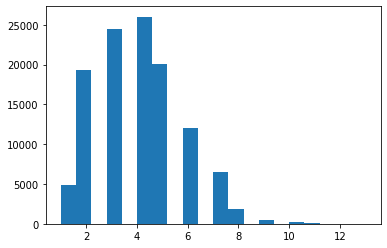

In [16]:
plt.hist(lengths,bins=20)

Load Embeddings

In [17]:
t_model = gensim.models.Word2Vec.load('../resources/models/word vectors/word2vec/wiki/full_grams_cbow_100_wiki/full_grams_cbow_100_wiki.mdl')

In [18]:
i2l = list(set(normalization(araby.LETTERS)))
i2v = {}
for index,letter in enumerate(i2l):
    if letter in t_model.wv.index_to_key :
        i2v[index] = t_model.wv.get_vector(letter)

In [19]:
i2v.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

In [20]:
i2l.append(' ')#Space
i2l.append('s')#eos
i2l.append('E')#Empty
i2l.append('X')#UNK
i2l.append('P')#pad

In [21]:
l2i = {v:i for i,v in enumerate(i2l)}

In [22]:
len(i2l)

34

ALL in Model

In [39]:
from torch.utils.data import Dataset,DataLoader

In [40]:
from torch.nn.utils.rnn import pad_sequence 

In [57]:
def noise(txt):
    sz = int(len(txt)*0.2)
    noise_sz = np.random.randint(0,sz if sz>1 else 1,1)
    replace_idx = np.random.choice(len(txt),noise_sz,replace=False)
    letters_idx = np.random.choice(len(i2l)-3,noise_sz,replace=True)
    txt = list(txt)
    for rep,let in zip(replace_idx,letters_idx):
        txt[rep] = i2l[let]
    return ''.join(txt)

In [186]:
class arrDs(Dataset):
    def __init__(self,txt_list,l2i):
        self.data = txt_list
        self.l2i = l2i
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        X = noise(self.data[idx])
        Y = self.data[idx]
        
        X = torch.tensor([self.l2i.get(i,31) for i in X])
        Y = torch.tensor([self.l2i.get(i,31) for i in Y])
        #numerilize
        return (X,Y)

In [187]:
trn_data, val_data = msa_data[:int(0.8*len(msa_data))],msa_data[int(0.8*len(msa_data)):]

In [188]:
trn_ds,val_ds = arrDs(trn_data,l2i),arrDs(val_data,l2i)

In [189]:
trn_ds[0]

(tensor([12, 21, 29, 21, 15,  2,  5, 29, 28, 21, 20, 11,  8, 29, 13,  8, 18,  7,
         29, 21, 12, 21, 29,  5,  2, 18, 24, 21, 29, 28, 29, 12,  8, 21, 29,  9,
          2,  5,  8, 29, 28, 29,  5, 27,  8, 21, 30, 21, 13,  8, 18]),
 tensor([18]))

In [276]:
def collate_fn(data):
    label  = [i for _,i in data]
    label = pad_sequence(label,batch_first=True,padding_value=32)
    data = [i for i,_ in data]
    data = pad_sequence(data,batch_first=True,padding_value=32)
    return label,label

In [277]:
trn_dl = DataLoader(trn_ds,batch_size=32,collate_fn=collate_fn,drop_last=False)
val_dl = DataLoader(val_ds,batch_size=32,collate_fn=collate_fn,drop_last=False)

Model

In [278]:
import torch, torch.nn as nn

In [279]:
class autocorrect(nn.Module):
    def __init__(self,num_emb,vs,hs,bidirectional=True):
        super().__init__()
        self.emb = nn.Embedding(num_emb,vs)
        self.gru = nn.GRU(vs,hs,num_layers=3,bidirectional=bidirectional,batch_first=True,dropout=0.2)
        self.lin = nn.Sequential(nn.Linear(2*hs if bidirectional == True else hs,hs),
                                 nn.ReLU(),
                                 nn.Linear(hs,num_emb))
    def forward(self,x):
        bs,seq_len=x.shape
        x = self.emb(x)
        x,_ = self.gru(x)
        x = nn.functional.relu(x)
        x = self.lin(x)
        return torch.softmax(x,dim=-1).view(bs*seq_len,-1)

In [280]:
num_emb = len(i2l)

In [281]:
model = autocorrect(num_emb,100,512).cuda()

In [282]:
#Load available vectors
model.emb.weight.requires_grad_(False)
for i in i2v.keys():
    model.emb.weight[i] = nn.Parameter(torch.from_numpy(i2v[i].copy())).requires_grad_(False)
model.emb.weight.requires_grad_(True);

In [283]:
opt = torch.optim.Adam(model.parameters(),lr=1e-3)

In [284]:
loss = nn.CrossEntropyLoss(ignore_index=32)

In [285]:
def train(epoch,model,val_dl,trn_dl,loss_fnc):
    model.train()
    for i in range(epoch):
        model.train()
        for batch in trn_dl:
            opt.zero_grad()
            ip,label = batch
            op = model(ip.cuda())
            trn_l = loss_fnc(op,label.view(-1).cuda())
            trn_l.backward()
            opt.step()
        
        with torch.no_grad():
            model.eval()
            for batch in val_dl:
                ip,label = batch
                op = model(ip.cuda())
                val_loss = loss_fnc(op,label.view(-1).cuda())
        print('train_loss ->',trn_l.item() , 'val_loss ->',val_loss.item())

In [287]:
train(4,model,trn_dl,val_dl,loss)

train_loss -> 2.825662136077881 val_loss -> 2.883354663848877
train_loss -> 3.1756622791290283 val_loss -> 3.191047191619873
train_loss -> 2.775662899017334 val_loss -> 3.1141245365142822
train_loss -> 3.025662899017334 val_loss -> 3.037201166152954


## N-Gram Model

In [45]:
import random

In [50]:
def get_ngrams(txt,ws=11):
    ignore = ws //2
    txt = list(txt)
    grams = ngrams(txt,ws ,pad_left=True,pad_right=True,left_pad_symbol='P',right_pad_symbol='P')
    return list(grams)[ignore:-ignore]

In [48]:
msa_grams=[]
for txt in msa_data:
    msa_grams.extend(get_ngrams(txt))

In [137]:
random.random()

0.6457555610677899

In [130]:
def noise(txt):
    replace_idx = len(txt)//2
    letter = txt[replace_idx]
    txt=list(txt)
    del txt[replace_idx]
    
    return ''.join(txt),letter

In [131]:
class arrDs(Dataset):
    def __init__(self,txt_list,l2i):
        self.data = txt_list
        self.l2i = l2i
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        X,Y = noise(self.data[idx])
        #numerilize
        X = torch.tensor([self.l2i.get(i,self.l2i['X']) for i in X])
        Y = torch.tensor([self.l2i.get(i,self.l2i['X']) for i in [Y]])
        
        return (X,Y)

In [132]:
trn_data, val_data = msa_grams[:int(0.8*len(msa_grams))],msa_grams[int(0.8*len(msa_grams)):]

In [133]:
trn_ds,val_ds = arrDs(trn_data,l2i),arrDs(val_data,l2i)

In [195]:
def collate_fn(data):
    label  = [i for _,i in data]
    #label = pad_sequence(label,batch_first=True,padding_value=32)
    data = [i for i,_ in data]
    data = pad_sequence(data,batch_first=True,padding_value=33)
    return data,label

In [196]:
trn_dl = DataLoader(trn_ds,batch_size=32,collate_fn=collate_fn,drop_last=False)
val_dl = DataLoader(val_ds,batch_size=32,collate_fn=collate_fn,drop_last=False)

In [197]:
next(iter(trn_dl))

(tensor([[12, 21, 29,  ..., 13,  8, 18],
         [21, 29, 21,  ...,  8, 18, 29],
         [29, 21, 15,  ..., 18, 29,  7],
         ...,
         [28, 29, 12,  ..., 29, 27, 17],
         [29, 12,  8,  ..., 27, 17, 28],
         [12,  8, 21,  ..., 17, 28, 25]]),
 [tensor([5]),
  tensor([7]),
  tensor([14]),
  tensor([7]),
  tensor([3]),
  tensor([1]),
  tensor([2]),
  tensor([11]),
  tensor([22]),
  tensor([3]),
  tensor([15]),
  tensor([14]),
  tensor([12]),
  tensor([14]),
  tensor([25]),
  tensor([2]),
  tensor([13]),
  tensor([27]),
  tensor([16]),
  tensor([25]),
  tensor([24]),
  tensor([16]),
  tensor([29]),
  tensor([7]),
  tensor([28]),
  tensor([21]),
  tensor([5]),
  tensor([19]),
  tensor([6]),
  tensor([10]),
  tensor([17]),
  tensor([28])])

Model

In [198]:
import torch, torch.nn as nn

In [247]:
class autocorrect(nn.Module):
    def __init__(self,num_emb,vs,hs,bidirectional=True):
        super().__init__()
        self.emb = nn.Embedding(num_emb,vs)
        self.enc_gru = nn.GRU(vs,hs,num_layers=1,bidirectional=False,batch_first=True,dropout=0.2)
        self.dec_gru = nn.GRU(vs,hs,num_layers=1,bidirectional=False,batch_first=True,dropout=0.2)
        self.lin = nn.Linear(hs,num_emb)
    def forward(self,x):
        
        bs,seq_len=x.shape
        print(bs)
        x = self.emb(x)
        _,x = self.gru(x)
        x = x.permute(1,0,2)
        x=x.reshape(32,-1)
        x = nn.functional.relu(x)
        x = self.lin(x)
        return torch.softmax(x,dim=-1).view(bs*seq_len,-1)

In [248]:
num_emb = len(i2l)

In [249]:
model = autocorrect(num_emb,100,512).cuda()

In [122]:
#Load available vectors
model.emb.weight.requires_grad_(False)
for i in i2v.keys():
    model.emb.weight[i] = nn.Parameter(torch.from_numpy(i2v[i].copy())).requires_grad_(False)
model.emb.weight.requires_grad_(True);

In [123]:
opt = torch.optim.Adam(model.parameters(),lr=1e-3)

In [124]:
loss = nn.CrossEntropyLoss(ignore_index=32)

In [125]:
def train(epoch,model,val_dl,trn_dl,loss_fnc):
    model.train()
    for i in range(epoch):
        model.train()
        for batch in trn_dl:
            opt.zero_grad()
            ip,label = batch
            op = model(ip.cuda())
            trn_l = loss_fnc(op,label.view(-1).cuda())
            trn_l.backward()
            opt.step()
        
        with torch.no_grad():
            model.eval()
            for batch in val_dl:
                ip,label = batch
                op = model(ip.cuda())
                val_loss = loss_fnc(op,label.view(-1).cuda())
        print('train_loss ->',trn_l.item() , 'val_loss ->',val_loss.item())

In [126]:
train(50,model,trn_dl,val_dl,loss)

train_loss -> 2.966956377029419 val_loss -> 2.9245524406433105
train_loss -> 2.8179426193237305 val_loss -> 2.78366756439209
train_loss -> 2.713853597640991 val_loss -> 2.6620876789093018
train_loss -> 2.671865463256836 val_loss -> 2.632185459136963
train_loss -> 2.6573901176452637 val_loss -> 2.611616373062134
train_loss -> 2.6203505992889404 val_loss -> 2.578900098800659
train_loss -> 2.6199350357055664 val_loss -> 2.5786995887756348
train_loss -> 2.612917900085449 val_loss -> 2.5740554332733154
train_loss -> 2.6128077507019043 val_loss -> 2.5739822387695312
train_loss -> 2.6127774715423584 val_loss -> 2.5739588737487793
train_loss -> 2.563910722732544 val_loss -> 2.573953866958618
train_loss -> 2.5590922832489014 val_loss -> 2.5646677017211914
train_loss -> 2.559047222137451 val_loss -> 2.5551881790161133
train_loss -> 2.558993101119995 val_loss -> 2.5551440715789795
train_loss -> 2.556666374206543 val_loss -> 2.5520050525665283
train_loss -> 2.5519909858703613 val_loss -> 2.5488660

# Seq to Seq

In [23]:
from torch.utils.data import Dataset,DataLoader

In [24]:
from torch.nn.utils.rnn import pad_sequence 

In [25]:
import random

In [26]:
def get_ngrams(txt,ws=5):
    ignore = ws-2
    txt = list(txt)
    grams = ngrams(txt,ws ,pad_left=True,pad_right=True,left_pad_symbol='Q',right_pad_symbol='W')
    return list(grams)[ignore:-ignore]

In [27]:
fake_data = ['ق' * 10]*1000

In [28]:
msa_grams=[]
for txt in fake_data:
    ng = get_ngrams(txt)
    if ng:
        msa_grams.extend(ng)

In [29]:
def noise(txt):
    sz = int(len(txt)*0.2)
    noise_sz = np.random.randint(0,sz if sz>1 else 1,1)
    replace_idx = np.random.choice(len(txt),noise_sz,replace=False)
    letters_idx = np.random.choice(len(i2l)-3,noise_sz,replace=True)
    txt = list(txt)
    for rep,let in zip(replace_idx,letters_idx):
        txt[rep] = i2l[let]
    return ''.join(txt)

In [30]:
class arrDs(Dataset):
    def __init__(self,txt_list,l2i):
        self.data = txt_list
        self.l2i = l2i
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        #X = noise(self.data[idx])
        X = self.data[idx]
        Y = self.data[idx]
        
        X = torch.tensor([self.l2i.get(i,31) for i in X])
        Y = torch.tensor([self.l2i.get(i,31) for i in Y])
        #numerilize
        return torch.stack([X,Y])

In [31]:
trn_data, val_data = msa_grams[:int(0.8*len(msa_grams))],msa_grams[int(0.8*len(msa_grams)):]

In [33]:
trn_ds,val_ds = arrDs(trn_data,l2i),arrDs(val_data,l2i)

In [34]:
ip = trn_ds[5]

In [35]:
trn_dl = DataLoader(trn_ds,batch_size=4,drop_last=False)
val_dl = DataLoader(val_ds,batch_size=4,drop_last=False)

In [36]:
ip,label = next(iter(trn_dl))[:,0,:],next(iter(trn_dl))[:,1,:]

Model

In [37]:
import torch, torch.nn as nn

In [69]:
class autocorrect(nn.Module):
    def __init__(self,num_emb,vs,hs,bidirectional=True):
        super().__init__()
        self.hs = hs
        self.emb = nn.Embedding(num_emb,vs)
        self.enc_gru = nn.GRU(vs,hs,num_layers=1,bidirectional=False,batch_first=True)
        self.dec_gru = nn.GRU(hs,hs,num_layers=1,bidirectional=False,batch_first=True)
        self.lin = nn.Sequential(nn.Linear(hs,hs),
                                 nn.ReLU(),
                                 nn.Linear(hs,num_emb))
    def forward(self,x):
        bs,seq_len=x.shape
        x = self.emb(x)
        #print('emb',x.shape)
        x = self.enc_gru(x)
        #print('enc',x[0].shape)
        op=[]
        sos = torch.zeros(bs,1,self.hs).cuda()
        h = x[1]
        for i in range(5):
            sos,h = model.dec_gru(sos,h)
            op.append(h)
        #    print('h',h.shape)
        x = torch.stack(op,dim=1).squeeze().permute(1,0,2)
        
        x = self.lin(x)
        #print('lin',x.shape)
        return torch.softmax(x,dim=-1).permute(0,2,1)

In [101]:
num_emb = len(i2l)

In [102]:
model = autocorrect(num_emb,5,6).cuda()

In [103]:
#Load available vectors
#model.emb.weight.requires_grad_(False)
#for i in i2v.keys():
#    model.emb.weight[i] = nn.Parameter(torch.from_numpy(i2v[i].copy())).requires_grad_(False)
#model.emb.weight.requires_grad_(True);

In [104]:
opt = torch.optim.Adam(model.parameters(),lr=1e-2)

In [105]:
loss = nn.CrossEntropyLoss(ignore_index=32)

In [106]:
def train(epoch,model,val_dl,trn_dl,loss_fnc):
    model.train()
    for i in range(epoch):
        model.train()
        for batch in tqdm.tqdm(trn_dl,'train'):
            opt.zero_grad()
            ip,label = batch[:,0,:],batch[:,1,:]
            op = model(ip.cuda())
            trn_l = loss_fnc(op,label.cuda())
            trn_l.backward()
            opt.step()
            print(trn_l)
        with torch.no_grad():
            model.eval()
            for batch in tqdm.tqdm(val_dl,'validation'):
                ip,label = batch[:,0,:],batch[:,1,:]
                op = model(ip.cuda())
                val_loss = loss_fnc(op,label.cuda())
        print('train_loss ->',trn_l.item() , 'val_loss ->',val_loss.item())

In [107]:
import tqdm

In [108]:
train(2,model,trn_dl,val_dl,loss)

train:  12%|█▏        | 49/400 [00:00<00:01, 245.70it/s]

tensor(3.5356, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(3.0183, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='c

train:  25%|██▌       | 100/400 [00:00<00:01, 248.66it/s]

tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='c

train:  38%|███▊      | 151/400 [00:00<00:01, 248.06it/s]

tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='c

train:  51%|█████     | 203/400 [00:00<00:00, 252.63it/s]

tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='c

train:  64%|██████▍   | 255/400 [00:01<00:00, 253.52it/s]

tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='c

train:  70%|███████   | 281/400 [00:01<00:00, 252.33it/s]

tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='c

train:  83%|████████▎ | 332/400 [00:01<00:00, 249.17it/s]

tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='c

train: 100%|██████████| 400/400 [00:01<00:00, 250.11it/s]


tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='c

validation: 100%|██████████| 1600/1600 [00:01<00:00, 1050.62it/s]


train_loss -> 2.6256630420684814 val_loss -> 2.6256630420684814


train:   6%|▌         | 24/400 [00:00<00:01, 239.86it/s]

tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='c

train:  12%|█▏        | 49/400 [00:00<00:01, 244.38it/s]

tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)


train:  18%|█▊        | 74/400 [00:00<00:01, 242.29it/s]

tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='c

train:  25%|██▌       | 100/400 [00:00<00:01, 247.64it/s]

tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)


train:  31%|███▏      | 125/400 [00:00<00:01, 244.91it/s]

tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='c

train:  44%|████▎     | 174/400 [00:00<00:00, 234.24it/s]

tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='c

train:  56%|█████▌    | 224/400 [00:00<00:00, 238.83it/s]

tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='c

train:  68%|██████▊   | 274/400 [00:01<00:00, 242.84it/s]

tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='c

train:  81%|████████  | 324/400 [00:01<00:00, 242.84it/s]

tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='c

train:  94%|█████████▎| 374/400 [00:01<00:00, 246.29it/s]

tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='c

train: 100%|██████████| 400/400 [00:01<00:00, 242.62it/s]


tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
tensor(2.6257, device='cuda:0', grad_fn=<NllLoss2DBackward>)


validation: 100%|██████████| 1600/1600 [00:01<00:00, 1068.68it/s]

train_loss -> 2.6256630420684814 val_loss -> 2.6256630420684814


In [58]:
d = next(iter(val_dl))

In [59]:
d.shape

torch.Size([4, 2, 5])

In [60]:
d.shape

torch.Size([4, 2, 5])

In [67]:
model(torch.randint(0,34,(4,5)).cuda()).argmax(-1)

emb torch.Size([4, 5, 5])
enc torch.Size([4, 5, 6])
h torch.Size([1, 4, 6])
h torch.Size([1, 4, 6])
h torch.Size([1, 4, 6])
h torch.Size([1, 4, 6])
h torch.Size([1, 4, 6])
lin torch.Size([4, 5, 34])


tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')

In [68]:
?nn.CrossEntropyLoss

In [135]:
nn.functional.cross_entropy(torch.rand(10,5,10),torch.randint(0,5,(10,10)))

tensor(1.6614)

In [455]:
import tqdm

In [461]:
?tqdm.tqdm

In [460]:
for i in tqdm.tqdm(range(10)):
    pass

100%|██████████| 10/10 [00:00<00:00, 137970.53it/s]


In [128]:
l = nn.CrossEntropyLoss()

In [129]:
l(torch.ones(5,10),torch.ones(5).type(torch.LongTensor))

tensor(2.3026)